## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy as gp
from tqdm import tqdm
from sklearn.linear_model import LassoCV
%matplotlib inline

## Read Data

In [2]:
#Read Data
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

#Insert Column for Beta 0
train.insert(1, 'X0', [1]*len(train))
test.insert(1, 'X0', [1]*len(test))
train.shape, test.shape

#Set Time Limit
time_limit = 3000

### 2.  In order to do cross validation on the MIQP model you will have to write your own cross  validation code. Randomly shuffle your data and split it into 10 folds. You can use the ‘np.random.choice()’ function in Python to shuffle your data. There are 50 X variables, and you will need to try k = 5, 10, 15, …, 50 in your cross validation. This means to do 10-fold cross validation with all possible values of k, you will have to solve an MIQP model 100 times! Pick the value of k that corresponds to the smallest cross validation error: for a given value of k, sum each validation set’s sum of squared errors using the Betas found using the other 9 folds’ data to solve the MIQP. When k is 5 or 50, gurobi should solve the problem pretty quickly, but when k is 25 it will probably take a long time. Therefore, you should set a time limit for gurobi to solve each problem. Don’t let the entire process run for any longer than 12 hours. Again, be smart about setting this up, so that you can run it once, save the results, and then import those results when you create the final version of your python code and pdf file. Also, set a time limit variable at the very beginning of your python code so that we can shorten the runtime of your code when we grade it.

### a. It is very important to remember that gurobi assumes all decision variables are non-negative. In order to allow your Betas to be negative or positive you must set the lb value of your model to be -M for the appropriate decision variables.

### b. It is also very important that you choose M to be large enough so that no value of Beta is equal to M or -M. If you solve the problem and one of your Betas is M or -M then you should double M and resolve the problem. Repeat this process until no Beta is equal to M or -M.

In [3]:
def KFold(data,K=10,shuffle=True,seed=42):
    
    '''Function to create K-Fold validation Index'''
    
    #Get Index
    train_indx = np.array(data.index)
    
    #Set Random Seed
    np.random.seed(seed)
    
    #Shuffle Data
    if shuffle:
        shuffled_index = np.random.choice(train_indx, size=len(train_indx), replace=False)
    
    #Split and Create Folds
    cv_index = np.split(shuffled_index, indices_or_sections= 10)
    kfold = [(np.concatenate(np.delete(cv_index,i,axis=0)), cv_index[i]) for i in range(len(cv_index))]
    
    return kfold

In [4]:
def Solver(m_var, A, sense, b, lb = None, ub = None, min_max = 'maximize', vtype = None, Q = None, L = None, C = 0, 
           show_output = False, time_limit = 3000):
    
    '''Function to solve quadratic in Gurobi'''
    
    # Model initialization
    model = gp.Model()
    
    # Variables initialization
    modelX = model.addMVar(m_var, lb=lb, ub=ub, vtype=vtype)
    
    # Constraint intialization
    modelConstr = model.addMConstr(A, modelX, sense, b)
    
    #  objective init
    if min_max == 'maximize':
        model.setMObjective(Q,L,C,sense=gp.GRB.MAXIMIZE)
    if min_max == 'minimize':
        model.setMObjective(Q,L,C, sense = gp.GRB.MINIMIZE)
    
    model.Params.OutputFlag = 0 # restricting output jargon
    model.Params.timeLimit = time_limit
    
    #Run optimizer
    model.optimize()
    
    if show_output:
        print("\nobjective value")
        print(model.objVal)
        print('-----------------------------------')

        print("\nvalues of variable X")
        print(modelX.x)

        print('-----------------------------------')
    
    return modelX.x

In [5]:
def MIQP(X, y, M = 2, k = 5, time_limit=3000):
    
    '''Function to for Beta with a subset of variables'''
    
    #Get m & n
    m = X.shape[1]-1
    n = X.shape[0]
    q = 2*m+1
    
    #Quadratic Component
    Q = np.zeros((2*m+1,2*m+1))
    Q[:(m+1),:(m+1)] = X.T@X
    
    #Linear Component
    L = np.array(list(-2 * y.T @ X) + [0]*m)

    ## Constraint Definition
    A = np.zeros((q,q))
    sense = np.array(['']*q)
    b = np.array([0]*q)

    #Initialize Counter
    row = 0
    
    # -Mz_j <= b_j
    A[row:row+m, 1:m+1] = np.identity(m)
    A[row:row+m, m+1:q] = M*np.identity(m)
    sense[row:row+m] = ['>']*m
    b[row:row+m] = [0]*m    
    
    #Increment Counter
    row+=m
    
    # b_j <= Mz_j 
    A[row:row+m, 1:m+1] = np.identity(m)
    A[row:row+m, m+1:q] = -1*M*np.identity(m)
    sense[row:row+m] = ['<']*m
    b[row:row+m] = [0]*m

    #Increment Counter
    row+=m
    
    # sum(z_j) = k
    A[row, m+1:q] = [1]*m
    sense[row] = '<'
    b[row] = k

    #Solve for Beta Values
    beta = Solver(m_var=q, A=A, sense=sense, b=b, lb=np.array([-M]*q), ub=np.array([M]*q),
                  min_max='minimize', vtype = ['C']*(m+1) + ['B']*m, time_limit=time_limit, Q=Q, L=L, C=0)
    
    return beta

In [6]:
#Sample Run
X = train.drop('y', axis =1)
y = train['y']

#Get Shape of m
m = X.shape[1]-1

#Solve for Beta
beta = MIQP(X, y, M=1000)

#Get Error
sq_err = (X @ beta[0:m+1] - y).T @ (X @ beta[0:m+1] - y)
mse    = sq_err/len(y)
mse

Academic license - for non-commercial use only - expires 2022-01-03
Using license file c:\gurobi912\gurobi.lic


3.4811394167311738

### Implement Cross-Validation to solve for optimal value of k (Number of Features)

In [7]:
#Dataframe for storing MSE
results = pd.DataFrame(columns = ['Number_of_Features','MSE'])

#Get only training data
X = train.drop('y', axis =1)
y = train['y']
m = X.shape[1]-1

#Big M value
M = 100
  
k_values = [5,10,15,20,25,30,35,40,45,50]
#Loop through values of k
for k in tqdm(k_values):
    
    #mse for each k
    mse_k = []
   
    #Loop through K-Folds
    for i, (train_indx, test_indx) in enumerate(KFold(X)):

        #Train-Test Split
        X_train, X_test, y_train, y_test = X.loc[train_indx], X.loc[test_indx], y.loc[train_indx], y.loc[test_indx]
        
        #Solve for Beta on Train Data
        beta = MIQP(X = X_train, y = y_train, k = k, M = M, time_limit = time_limit)

        #MSE of Test Data
        sq_error = (X_test @ beta[0:m+1] - y_test).T @ (X_test @ beta[0:m+1] - y_test)
        mse      = sq_error//len(y_test)
        
        #Append MSE
        mse_k.append(mse)
    
    #Add mean MSE for corresponding k value
    results.loc[len(results)] = [k , np.mean(mse_k)]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [47:12<00:00, 283.28s/it]


In [16]:
#display results
results

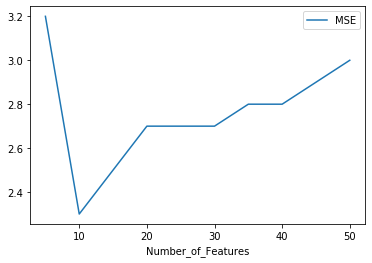

In [9]:
results.set_index('Number_of_Features').plot(kind='line')

In [10]:
best_k = int(results.set_index('Number_of_Features').idxmin())
print(f"Best k value is: {best_k}")

Best k value is: 10


### 3. Once you find the k with the smallest cross validation error, fit the MIQP model on the entire training set using that value of k. Use the Betas you find in this MIQP to make a prediction of the y values in the test set.

### Run on entire train and test data using best k value

In [18]:
X_train, X_test, y_train, y_test = train.drop('y', axis = 1),  test.drop('y', axis = 1), train['y'], test['y']

#Running model on entire train set
beta = MIQP(X = X_train, y = y_train, k = best_k, M = 2, time_limit = time_limit)

m = X_train.shape[1]-1

#Evaluating model on entire test set
sq_error = (X_test @ beta[0:m+1] - y_test).T @ (X_test @ beta[0:m+1] - y_test)
mse      = sq_error/len(y_test)

print(f"MSE for best k [{best_k}] value is: {round(mse,2)}")

MSE for best k [10] value is: 2.23


## 4. Use scikit learn to do 10-fold cross validation on the training set to pick Betas Once you find the best value of Betas, fit a LASSO model to the entire training set using that value of Betas With the Betas you find in that LASSO model make a prediction of the y values in the test set.

In [23]:
#Sklearns LassoCV
lasso = LassoCV(cv=10, random_state=42).fit(X_train, y_train)

#Best Regularization parameter from 10 fold CV
alpha = lasso.alpha_
print(f"Regularization Parameter Alpha for sklearn Lasso CV is: {round(alpha,3)}")

Regularization Parameter Alpha for sklearn Lasso CV is: 0.076


In [24]:
#Get Beta Values
beta = lasso.coef_

#Calculate Squared Error
sq_error = (X_test @ beta - y_test).T @ (X_test @ beta - y_test)
mse      = sq_error/len(y_test)
print(f"MSE for sklearn Lasso CV value is: {round(mse,2)}")

MSE for sklearn Lasso CV value is: 3.59


In [25]:
#Display Number of Features Selected
n_features = sum(lasso.coef_[1:] != 0)
print(f"Features selected in sklearn Lasso CV is: {n_features}")

Features selected in sklearn Lasso CV is: 17
